Install dan import semua kebutuhan

In [4]:
# jalankan jika buka dengan google colab
!pip install scikit-learn-extra
!pip install -U yellowbrick
!pip install pyclustering

In [1]:
import pandas as pd
import numpy as np

# save model
import os
import pickle

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
import scipy

from wordcloud import WordCloud
import matplotlib.pyplot as plt
import matplotlib

from yellowbrick.cluster import KElbowVisualizer

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn_extra.cluster import KMedoids
from pyclustering.cluster.center_initializer import random_center_initializer
from pyclustering.cluster.xmeans import xmeans as XMeans
import time

from sklearn import metrics

# Load Cleaned Data

Data diakses dari repository github agar dapat mudah dijalankan di Google Colab tanpa perlu upload datanya terlebih dahulu. Data dalam bentuk *tab-separated value* (tsv) makanya perlu tambahkan argumen '\\t' pada parameter 'sep' yang berarti tab.

In [2]:
data_path = 'https://raw.githubusercontent.com/zeerafle/text-mining-clustering/master/data/location-based-dataset.tsv'
data = pd.read_csv(data_path, sep='\t', index_col='Id')
data.head()

,text,user_location
Id,,
0,halo selamat baca lepas pro kontra makin banya...,"Tasikmalaya, Jawa Barat"
1,semua orang antri era presiden bingung vaksin ...,jawa tengah
2,istri mau vaksin kata sampa sana suruh pulang ...,#JagakarsaCity
3,sabar dulu vaksin jujur tanya tugas sehat anjur,#JagakarsaCity
4,gais kalau demam vaksin lepaih telan obat dema...,#cyberjaya #putrajaya #melaka


In [3]:
data.text[121]

'bumi lama perkosa nafsu manusia manusia bicara hikmah mimbar agama agama ajar hikmah muncul virus corona bahkan terus bohong vaksin sakit sebut wabah landa kini henti jenak binasa'

In [4]:
len(data)

2004

Ambil data yang kalimatnya lebih dari 2 kata

In [5]:
word_count = pd.Series(list(map(lambda x: len(str(x).split(" ")), data.text)))

word_count.describe()

count    2004.000000
mean       13.957585
std         8.198590
min         1.000000
25%         7.000000
50%        12.000000
75%        20.000000
max        41.000000
dtype: float64

In [6]:
data = data.loc[word_count > 2]
len(data)

1952

Data teks lebih dari 2 kata tersisa 1952 tweet

# Term Frequencies
TF (*Term Frequency*) adalah frekuensi dari kemunculan sebuah istilah dalam dokumen yang bersangkutan. Semakin besar jumlah kemunculan suatu term (TF tinggi) dalam dokumen, semakin besar pula bobotnya atau akan memberikan nilai keseuaian yang semakin besar. Berikut rumusnya:

$$
tf_{i,j} = \frac{n_{i,j}}{\sum_{k}n_{i,j}}
$$

Semerntara itu IDF merupakan sebuah perhitungan dari bagaimana term didistribusikan secara luas pada koleksi dokumen yang bersangkutan. IDF menunjukkan hubungan ketersediaan sebuah istilah dalam seluruh dekomuen. Semakin sedikit jumlah dokumen yang mengandung term yang dimaksud, maka nilai IDF semakin besar. IDF dihitung dengan:

$$
idf(w) = log(\frac{N}{df_{t}})
$$

Dengan mengombinasikan dua persamaan diatas kita dapat menemukan kata yang penting dalam dokumen (tweet). Rumus TF-IDF score adalah:

$$
w_{i,j} = tf_{i,j} * log(\frac{N}{df_{t}})
$$

---
**Referensi**
- [Text Mining dengan K-Means Clustering pada Tema LGBT dalam Arsip Tweet Masyarakat Kota Bandung](https://core.ac.uk/download/pdf/235583628.pdf)

In [7]:
# Untuk mengaplikasikan tf-idf, inputnya harus berupa list of tweet
tweets = data.text.to_list()
tweets[112:119]

['vaksin sehat sehat',
 'tenang perut sakit lapar jatah nasi milik surat vaksin sakit lemah fisik paksa vaksin bantu beras vaksin bantu sosial jerat leher orang lemah',
 'info vaksin kabupaten bandung lokasi telkom university stadion jalak daftar online dulu',
 'info vaksin kabupaten bandung lokasi telkom university stadion burung jalak daftar online dulu',
 'eh vaksin sekarang kmrb obgyn izin pusat vaksin izin',
 'qatar sama bahkan milik barcode sendiri status vaksinasi status isolasi berapa kali tangkap scan cerita isoman pura pura sehat orang sepupu eksentrik memberitahu',
 'obrol sore vaksin ibu laundry belah kost nya ouh mas vaksin efek mba efek kok minggu minggu sejak vaksinasi orang orang belakang vaksinasi orang tinggal antivaxx']

Pertama inisialisasi instance. Saat inisialisasi masukkan argumen berikut:
- `max_features`: jumlah maksimal fitur. `None` secara default
- `min_df`: jumlah minimal sebuah fitur muncul. Bernilai 5 berarti minimal sebuah fitur harus muncul setidaknya 5 kali.
- `ngram_range`: rentang ngram. Ngram maksudnya jumlah kombinasi kata. Rentang ngram dari 1 hingga 2 berarti kita memasukkan baik yang berjumlah 1 kata ataupun 2 kata kedalam pembobotan.

Selanjutnya, jalankan fungsi `fit_transform`, masukkan argumen `tweets`. Simpan hasilnya kedalam variabel baru

In [8]:
tfidf = TfidfVectorizer(max_features=None,
                       min_df=5,
                       ngram_range=(1,2))
features = tfidf.fit_transform(tweets)

print(features.shape)

(1952, 1281)


## Term Document Matrix Untuk Pembobotan TF-IDF

Ini matriksnya jika dibuat dalam tabel. Atau disebut juga **Term Document Matrix**

In [9]:
tdm_tfidf = pd.DataFrame(features.toarray(), index=['tweet ' + str(i+1) for i in range(len(data))])
tdm_tfidf.columns = tfidf.get_feature_names()
tdm_tfidf.head()

,abai,acara,adik,admin,administrasi,agama,agustus,ah,ahli,air,...,warga,warga negara,waspada,wib,widodo,wilayah,wkwkwk,yakin,yogyakarta,yuk
tweet 1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
tweet 2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
tweet 3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
tweet 4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
tweet 5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Dalam matriks tersebut, kata *vaksin* dan *vaksinasi* masih masuk dalam pembobotan. Sedangkan, kedua kata tersebut adalah kata kunci pada pencarian tweet ini. Maka jelas bobotnya paling besar.

Jadi kita buang dulu fitur ini. Atau dalam hal tabel matriks ini kita buang kolom yang bernama 'vaksin' dan 'vaksinasi'. Setelah dibuang, kembalikan lagi tabel diatas kebentuk matriks.

In [10]:
tdm_tfidf.drop(['vaksin', 'vaksinasi'], axis=1, inplace=True)
features = scipy.sparse.coo_matrix(tdm_tfidf.values)
features.shape

(1952, 1279)

In [11]:
tdm_tfidf.sum(axis=0).sort_values()

aja kalau          1.083394
sendiri orang      1.186392
segera mungkin     1.208815
ponsel             1.238417
formulir           1.243415
                    ...    
jadi              33.468572
sehat             34.223094
mau               35.160687
orang             42.244026
covid             55.476404
Length: 1279, dtype: float64

# Clustering

In [12]:
# untuk menampilkan top 10 words tiap cluster
def show_top_terms(cluster_centers, tfidf_matrix=features, terms=tfidf.get_feature_names()):
    """Fungsi ini menampilkan top 10 fitur dari setiap cluster
    
    Parameters:
        cluster_centers (array-like): Cluster center yang diakses dari model
        tfidf_matrix (sparse matrix): Matriks tf-idf. Default features
        terms (list): Kumpulan fitur fitur
    
    Returns: None
    """
    print("Top terms per cluster:")
    order_centroids = cluster_centers.argsort()[:, ::-1]

    num_of_cluster = cluster_centers.shape[0]
    for i in range(num_of_cluster):
        print("Cluster %d:" % i),
        for ind in order_centroids[i, :num_of_cluster]:
            print(' %s' % terms[ind])
        print()

In [13]:
# saving model
def save_model(filename, model):
    """Menyimpan model dalam direktori dumps/trained_models/location-based
    
    Parameters:
        filename (string): 
    """
    os.makedirs(os.path.dirname("dumps/trained_models/location-based/"), exist_ok=True)

    with open('dumps/trained_models/location-based/' + filename, 'wb') as f:
        pickle.dump(model, f)
        f.close()

# loading model
def load_model(filename):
    with open('dumps/trained_models/location-based' + filename, 'rb') as f:
        return pickle.load(f)

In [14]:
# labelling

# getting top 10 features
def get_top_features(cluster_centers, terms=tfidf.get_feature_names()):
    top_10_features = []
    current_cluster = []
    order_centroids = cluster_centers.argsort()[:, ::-1]
    
    num_of_cluster = cluster_centers.shape[0]
    for i in range(num_of_cluster):
        for ind in order_centroids[i, :10]:
            current_cluster.append(terms[ind])
        top_10_features.append(current_cluster)
        current_cluster = []
    
    return top_10_features

# create topic table
def create_topic_table(cluster_centers):
    num_of_cluster = cluster_centers.shape[0]
    table = pd.DataFrame({"terms": get_top_features(cluster_centers), "cluster": range(num_of_cluster)})
    table.terms = table.terms.apply(lambda x : ", ". join(x))
    
    return table

In [15]:
# create plot
def create_plot(model_labels, cluster_centers, title, tfidf_matrix=features):
    pca = PCA(n_components=2)
    scatter_plot_points = pca.fit_transform(tfidf_matrix.toarray())
    centroid_plot = pca.fit_transform(cluster_centers)
    
    unique_labels = set(model_labels)
    colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]
    
    for k, col in zip(unique_labels, colors):
        class_member_mask = model_labels == k
        
        xy = scatter_plot_points[class_member_mask]
        plt.plot(
            xy[:, 0],
            xy[:, 1],
            "o",
            markerfacecolor=tuple(col),
            markeredgecolor="k",
            markersize=6,
        )

    plt.plot(
        centroid_plot[:, 0],
        centroid_plot[:, 1],
        "o",
        markerfacecolor="cyan",
        markeredgecolor="k",
        markersize=10,
    )

    plt.title(title)


In [16]:
# worcloud visualization
def create_wordcloud(result_table):
    import math
    
    num_of_cluster = len(result_table.cluster.unique())
    pict_row = math.ceil(num_of_cluster/2)
    
    fig, ax = plt.subplots(pict_row, 2, figsize=(10,15))
        
    for column in range(2):
        for row in range(pict_row):
            i = 0
            s = result_table[result_table.cluster == i]
            text = s['tweet'].str.cat(sep=' ')
            text = text.lower()
            text = ' '.join([word for word in text.split()])
            wordcloud = WordCloud(max_font_size=50, max_words=100,
                                 background_color='white').generate(text)
            
            try:
                ax[row, column].imshow(wordcloud, interpolation='bilinear')
                ax[row, column].axis('off')
                ax[row, column].set_title("Cluster" + str(row+column*pict_row))
            except IndexError:
                ax[column].imshow(wordcloud, interpolation='bilinear')
                ax[column].axis('off')
                ax[column].set_title("Cluster" + str(row+column*pict_row))
            i += 1

## K-Means Clustering

### Find Best Number of Cluster

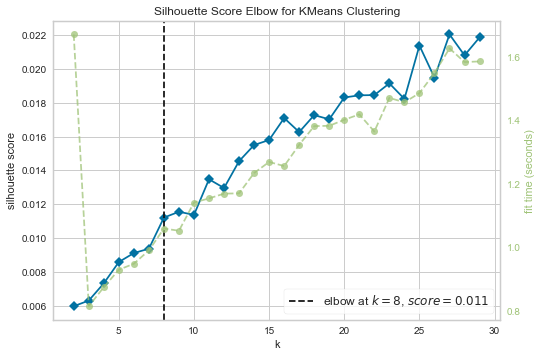

<AxesSubplot:title={'center':'Silhouette Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='silhouette score'>

In [46]:
# k is range of number of clusters.
visualizer = KElbowVisualizer(KMeans(algorithm='full', random_state=1), k=(2,30), metric='silhouette', timings=True)
visualizer.fit(features)        # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure

### Training

In [47]:
kmeans = KMeans(8, random_state=1, algorithm='full')
kmeans.fit(features)

KMeans(algorithm='full', random_state=1)

In [49]:
save_model('kmeans.model', kmeans)

In [ ]:
# jalankan jika sudah save model
kmeans = load_model('kmeans.model')

### Labelling

In [51]:
create_topic_table(kmeans.cluster_centers_)

,terms,cluster
0,"orang, orang orang, orang vaksinasi, covid, ba...",0
1,"jadi, hari, kalau, apa, lebih, anak, daftar, s...",1
2,"sinovac, vaksin siap, bagai, china, pandemi, p...",2
3,"sertifikat, sertifikat vaksin, syarat, min, ka...",3
4,"sehat, kasih, terima kasih, terima, ppkm, prot...",4
5,"covid, vaksin corona, vaksinasi anak, anak, in...",5
6,"mau, mau vaksin, kalau, kalau mau, dulu, jadi,...",6
7,"dosis, mana, tahu, puskesmas, pertama, informa...",7


### Plotting Cluster

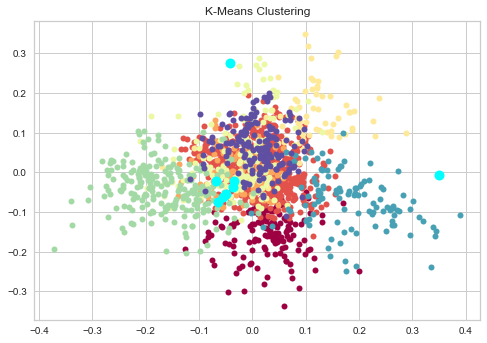

In [67]:
create_plot(kmeans.labels_, kmeans.cluster_centers_, 'K-Means Clustering')

### Wordcloud per cluster

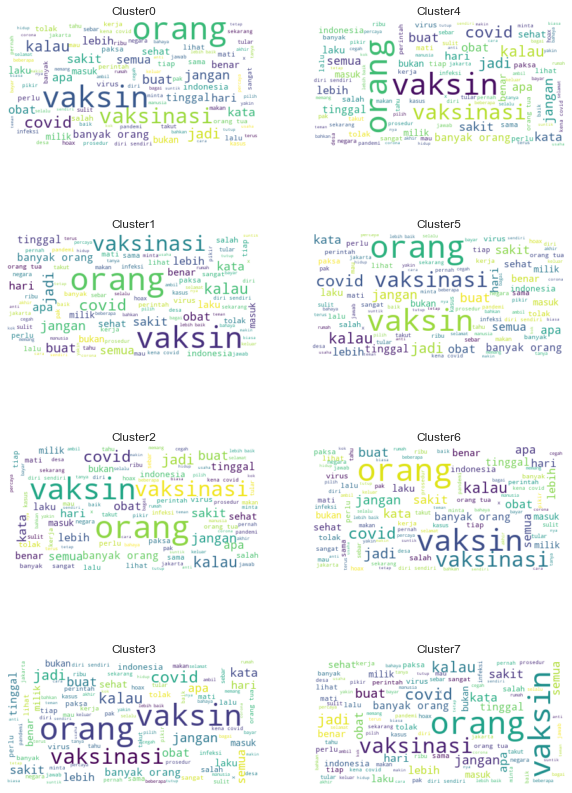

In [68]:
result_kmeans = pd.DataFrame({"tweet": tweets, "cluster": kmeans.labels_})

create_wordcloud(result_kmeans)

In [69]:
result_kmeans.cluster.value_counts()

1    924
5    223
7    166
4    159
0    158
2    148
6    109
3     65
Name: cluster, dtype: int64

## K-Medoids Clustering

### Find Best Number of Cluster

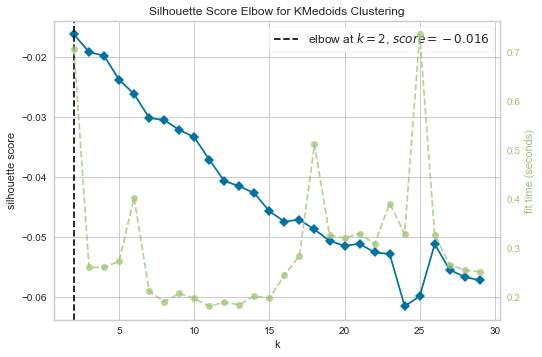

<AxesSubplot:title={'center':'Silhouette Score Elbow for KMedoids Clustering'}, xlabel='k', ylabel='silhouette score'>

In [17]:
# k is range of number of clusters.
visualizer = KElbowVisualizer(KMedoids(init='random',
                                       random_state=1),
                              k=(2,30),
                              metric='silhouette',
                              timings=True)
visualizer.fit(features)        # Fit the data to the visualizer
visualizer.show()               # Finalize and render the figure

### Training

In [18]:
kmedoids = KMedoids(2, random_state=1,
                    init='random', method='pam')
kmedoids.fit(features)

KMedoids(init='random', method='pam', n_clusters=2, random_state=1)

In [19]:
save_model('kmedoids.model', kmedoids)

In [ ]:
kmedoids = load_model('kmedoids.model')

### Labelling

In [20]:
create_topic_table(kmedoids.cluster_centers_.toarray())

,terms,cluster
0,"yakin, jabat, istirahat, istri, isu, ivermecti...",0
1,"undang vaksinasi, cukup tunjuk, krl, krl hari,...",1


### Plotting Cluster

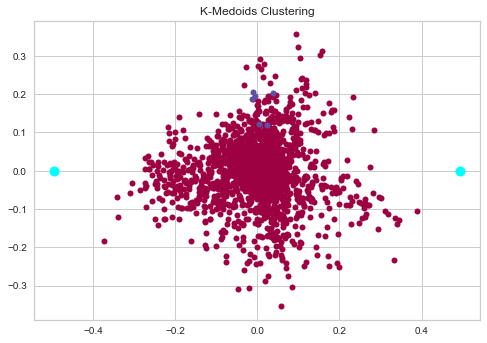

In [22]:
create_plot(kmedoids.labels_, kmedoids.cluster_centers_.toarray(), 'K-Medoids Clustering')

### Wordcloud per cluster

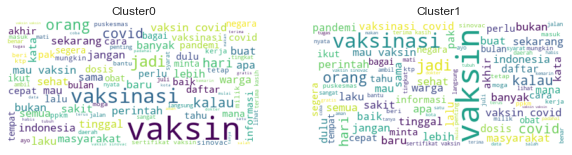

In [23]:
result_kmedoids = pd.DataFrame({"tweet": tweets, "cluster": kmedoids.labels_})

create_wordcloud(result_kmedoids)

In [24]:
result_kmedoids.cluster.value_counts()

0    1946
1       6
Name: cluster, dtype: int64

## Accelerated K-Means

### Find Best Number of Cluster

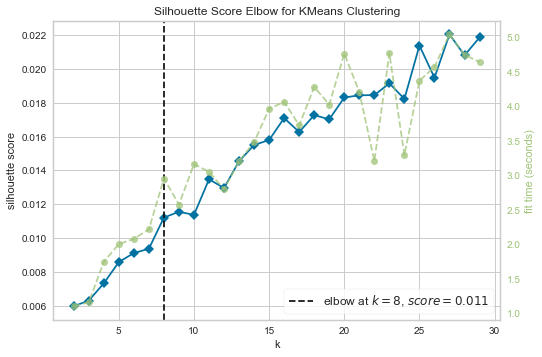

<AxesSubplot:title={'center':'Silhouette Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='silhouette score'>

In [25]:
# k is range of number of clusters.
visualizer = KElbowVisualizer(KMeans(algorithm='elkan',
                                     random_state=1),
                              k=(2,30),
                              metric='silhouette',
                              timings=True)
visualizer.fit(features)        # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure

### Training

In [26]:
acc_kmeans = KMeans(8, random_state=1, algorithm='elkan')
acc_kmeans.fit(features)

KMeans(algorithm='elkan', random_state=1)

In [27]:
save_model('acc_kmeans.model', acc_kmeans)

In [ ]:
# jalankan jika sudah save model
acc_kmeans = load_model('acc_kmeans.model')

### Labelling

In [28]:
create_topic_table(acc_kmeans.cluster_centers_)

,terms,cluster
0,"orang, orang orang, orang vaksinasi, covid, ba...",0
1,"jadi, hari, kalau, apa, lebih, anak, daftar, s...",1
2,"sinovac, vaksin siap, bagai, china, pandemi, p...",2
3,"sertifikat, sertifikat vaksin, syarat, min, ka...",3
4,"sehat, kasih, terima kasih, terima, ppkm, prot...",4
5,"covid, vaksin corona, vaksinasi anak, anak, in...",5
6,"mau, mau vaksin, kalau, kalau mau, dulu, jadi,...",6
7,"dosis, mana, tahu, puskesmas, pertama, informa...",7


### Plotting Cluster

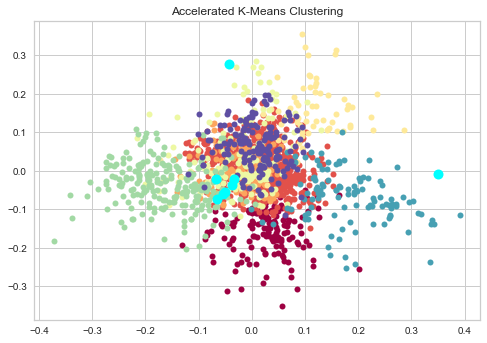

In [30]:
create_plot(acc_kmeans.labels_, acc_kmeans.cluster_centers_, 'Accelerated K-Means Clustering')

### Wordcloud per cluster

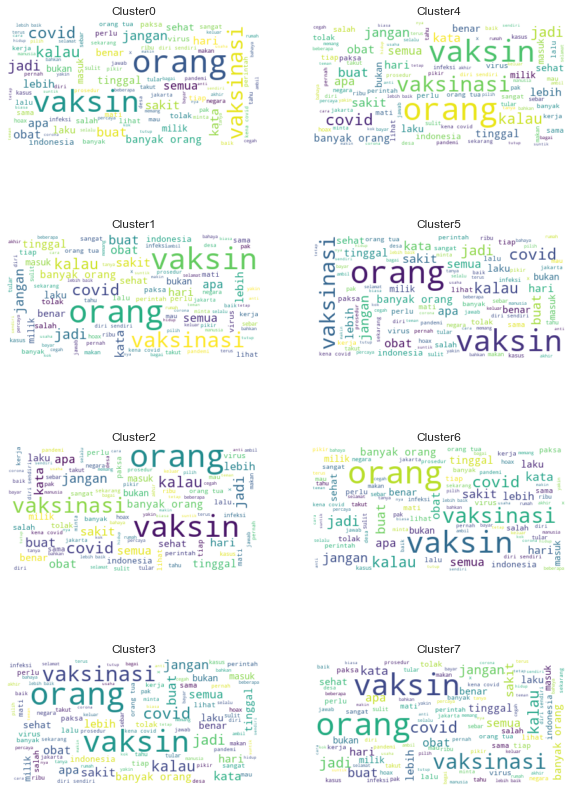

In [31]:
result_acc_kmeans = pd.DataFrame({"tweet": tweets, "cluster": acc_kmeans.labels_})

create_wordcloud(result_acc_kmeans)

In [32]:
result_acc_kmeans.cluster.value_counts()

1    924
5    223
7    166
4    159
0    158
2    148
6    109
3     65
Name: cluster, dtype: int64

## X-Means

### Find Best Number of Cluster

In [17]:
silhouette_scores = []
exec_time = []
for i in range(2,30):
    t0 = time.time()
    
    initial_centers = random_center_initializer(features.toarray(), i, random_state=1).initialize()
    xmeans_model = XMeans(features.todense(), initial_centers, i, random_state=1)
    xmeans_model.process()
    t1 = time.time() - t0
    
    exec_time.append(t1)
    
    xmeans_cluster = pd.Series(dtype='int64')
    for cluster_num, cluster in enumerate(xmeans_model.get_clusters()):
        for tweet_index in cluster:
            xmeans_cluster.at[tweet_index] = cluster_num
    
    xmeans_cluster.sort_index(inplace=True)
    
    silhouette_scores.append(metrics.silhouette_score(features, xmeans_cluster.to_numpy()))

In [20]:
with open('dumps/variables/silhouette_scores.pickle', 'rb') as f:
    silhouette_scores = pickle.load(f)
with open('dumps/variables/exec_time.pickle', 'rb') as f:
    exec_time = pickle.load(f)

In [18]:
elbow_point = silhouette_scores[0]
for i in range(len(silhouette_scores)):
    if elbow_point > silhouette_scores[i]:
        elbow_point = silhouette_scores[i-1]
        break

In [19]:
elbow_point = np.array(elbow_point,)
vline_index = np.where(silhouette_scores == elbow_point)
vline = vline_index[0][0] + 2    # karena iterasi dimulai dari jumlah cluster 2
vline

23

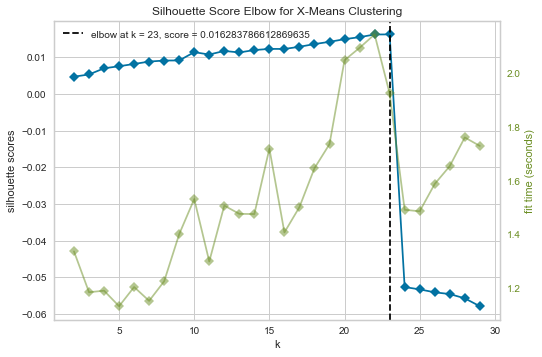

In [20]:
fig1 = matplotlib.figure.Figure()  # Make a figure
ax1 = fig1.add_subplot()           # Add the primary axis
ax1.plot(range(2,30), silhouette_scores, marker='D')        # Plot something
ax1.set_ylabel('silhouette scores')
ax1.set_xlabel('k')
ax1.set_title('Silhouette Score Elbow for X-Means Clustering')
dotted_line = ax1.axvline(vline, color='black', ls='--')
ax1.legend([dotted_line], [f'elbow at k = {vline}, score = {silhouette_scores[vline_index[0][0]]}'])

ax2 = ax1.twinx()                  # Add the secondary axis
ax2.plot(range(2,30), exec_time, color='olivedrab', marker='D', alpha=0.5)
ax2.grid(False)
ax2.set_ylabel('fit time (seconds)', color='olivedrab')
ax2.tick_params(axis='y', colors='olivedrab')
display(fig1)

### Training

In [21]:
initial_centers = random_center_initializer(features.toarray(), 23).initialize()
xmeans = XMeans(features.todense(), initial_centers, 23)
xmeans.process()

In [22]:
save_model('xmeans.model', xmeans)

In [ ]:
# jalankan jika sudah save model
xmeans = load_model('xmeans.model')

### Labelling

In [23]:
create_topic_table(np.array(xmeans.get_centers()))

,terms,cluster
0,"orang, orang orang, buat, orang vaksinasi, ora...",0
1,"cegah, gejala, covid, varian delta, tular, cor...",1
2,"kasih, terima, terima kasih, informasi, jadwal...",2
3,"apa, sehat, jadi, kalau, daftar, jangan, ktp, ...",3
4,"efek, bagus, lambat, coba, efek samping, sampi...",4
5,"covid, vaksinasi anak, vaksin corona, indonesi...",5
6,"hari, vaksin hadap, hari vaksin, tiap, baik, t...",6
7,"mau, mau vaksin, kalau, kalau mau, dulu, hari,...",7
8,"benar, benar benar, memang benar, orang, meman...",8
9,"bangun, lapar, selesai, tidur, siang, kemarin,...",9


### Plotting Cluster

In [24]:
xmeans_cluster = pd.Series(dtype='int64')
for cluster_num, cluster in enumerate(xmeans.get_clusters()):
    for tweet_index in cluster:
        xmeans_cluster.at[tweet_index] = cluster_num
    
xmeans_cluster.sort_index(inplace=True)

result_xmeans = pd.concat(
    [pd.DataFrame({'tweet': tweets}),
     pd.DataFrame({'cluster': xmeans_cluster})],
    axis=1)

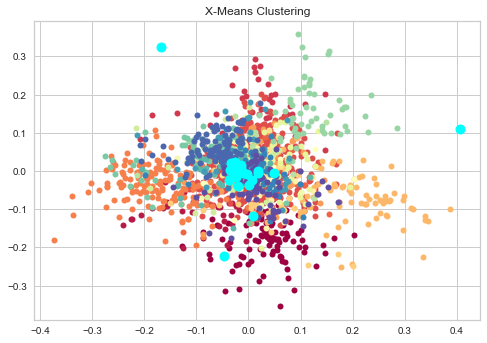

In [25]:
create_plot(result_xmeans.cluster.to_numpy(),
            np.array(xmeans.get_centers()),
            'X-Means Clustering')

### Wordcloud per cluster

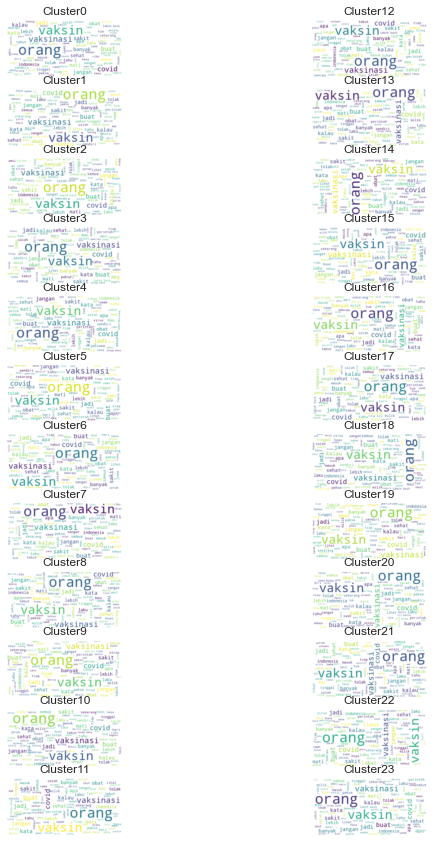

In [26]:
create_wordcloud(result_xmeans)

In [27]:
result_xmeans.cluster.value_counts()

3     728
5     149
21    112
0     107
7      76
22     74
6      66
14     60
16     59
19     50
2      50
17     45
8      44
1      43
13     42
4      41
18     40
20     39
9      31
15     29
12     25
11     23
10     19
Name: cluster, dtype: int64